# Домашнее задание: Деревья. Случайный лес
**Выполнено Кучевым Антоном, группы М8О-109СВ-24**

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [200]:
import numpy as np

# Распределение классов
n_k1 = 2
n_k2 = 8
n_total = n_k1 + n_k2


# Вероятности
p_k1 = n_k1 / n_total
p_k2 = n_k2 / n_total

# Энтропия: H = -sum(p_i * ln(p_i))
entropy = - (p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2))

print(f'Энтропия: {entropy:.2f}')

Энтропия: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [201]:
# Исходный индекс Джини
gini_total = 1 - (p_k1**2 + p_k2**2)

# Левое поддерево: только k_1
gini_left = 1 - (1**2 + 0**2)

# Правое поддерево: только k_2
gini_right = 1 - (0**2 + 1**2)

# Критерий информативности: Q = H(R_m) - (N_l/N) H(R_l) - (N_r/N) H(R_r)
Q = gini_total - (n_k1 / n_total) * gini_left - (n_k2 / n_total) * gini_right

print(f'Критерий информативности: {Q:.2f}')

Критерий информативности: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

В задаче регрессии при использовании решающего дерева предсказание модели в листовой вершине делается как среднее значение целевой переменной по всем объектам в этом листе.

In [202]:
# Значения целевой переменной
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

# Предсказание: среднее значение
prediction = np.mean(values)

print(f'Предсказание: {prediction:.1f}')

Предсказание: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [203]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [204]:
import numpy as np

def find_best_split(feature_vector, target_vector, task='classification', feature_type='real'):
    """
    Находит оптимальное разбиение для признака.
    
    Аргументы:
        feature_vector: Вектор значений признака.
        target_vector: Вектор целевой переменной.
        task: 'classification' или 'regression'.
        feature_type: 'real' или 'categorical'.
    
    Возвращает:
        thresholds: Список возможных порогов.
        scores: Список значений критерия для каждого порога.
        best_threshold: Оптимальный порог.
        best_score: Значение критерия для оптимального порога.
    """
    # Удаляем NaN и сортируем
    mask = ~np.isnan(feature_vector) & ~np.isnan(target_vector)
    feature_vector = feature_vector[mask]
    target_vector = target_vector[mask]
    
    if len(feature_vector) == 0:
        return None, None, None, None
    
    # Уникальные значения признака
    unique_features = np.unique(feature_vector)
    if len(unique_features) <= 1:
        return None, None, None, None
    
    if feature_type == 'real':
        # Пороги как средние между соседними значениями
        thresholds = (unique_features[:-1] + unique_features[1:]) / 2
    else:
        # Для категориальных признаков пороги - это сами значения
        thresholds = unique_features
    
    scores = []
    
    # Векторизованный расчет критерия
    sorted_indices = np.argsort(feature_vector)
    feature_sorted = feature_vector[sorted_indices]
    target_sorted = target_vector[sorted_indices]
    
    for threshold in thresholds:
        if feature_type == 'real':
            left_mask = feature_sorted <= threshold
        else:
            left_mask = feature_sorted == threshold
        
        right_mask = ~left_mask
        
        left_targets = target_sorted[left_mask]
        right_targets = target_sorted[right_mask]
        
        if len(left_targets) == 0 or len(right_targets) == 0:
            scores.append(-np.inf)
            continue
        
        if task == 'classification':
            # Индекс Джини
            def gini(targets):
                _, counts = np.unique(targets, return_counts=True)
                probs = counts / len(targets)
                return 1 - np.sum(probs**2)
            
            gini_total = gini(target_sorted)
            gini_left = gini(left_targets)
            gini_right = gini(right_targets)
            
            score = gini_total - (len(left_targets) / len(target_sorted)) * gini_left \
                              - (len(right_targets) / len(target_sorted)) * gini_right
        else:
            # Уменьшение дисперсии
            var_total = np.var(target_sorted)
            var_left = np.var(left_targets) if len(left_targets) > 1 else 0
            var_right = np.var(right_targets) if len(right_targets) > 1 else 0
            
            score = var_total - (len(left_targets) / len(target_sorted)) * var_left \
                              - (len(right_targets) / len(target_sorted)) * var_right
        
        scores.append(score)
    
    scores = np.array(scores)
    if len(scores) == 0 or np.all(scores == -np.inf):
        return None, None, None, None
    
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]
    
    return thresholds, scores, best_threshold, best_score

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [205]:
!pip3 install scikit-learn

In [206]:
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

print(boston.DESCR)
X.head()

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

/Users/anton/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

Лучший порог: 6.69
Наилучшее значение критерия (уменьшение дисперсии): 16.3363


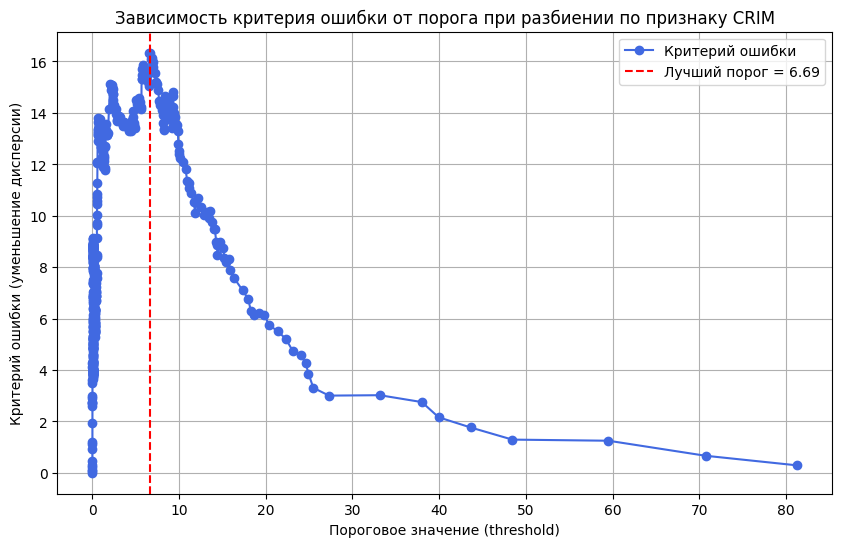

In [207]:
thresholds, scores, best_threshold, best_score = find_best_split(
    X["CRIM"].to_numpy(),
    y.to_numpy(),
    task="regression",
    feature_type="real"
)

print(f"Лучший порог: {best_threshold:.2f}")
print(f"Наилучшее значение критерия (уменьшение дисперсии): {best_score:.4f}")

plt.figure(figsize=(10, 6))
if thresholds.size > 0:
    plt.plot(thresholds, scores, marker='o', linestyle='-', color='royalblue', label="Критерий ошибки")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Лучший порог = {best_threshold:.2f}")
else:
    print("График не построен: нет допустимых порогов для разбиения.")
plt.title("Зависимость критерия ошибки от порога при разбиении по признаку CRIM")
plt.xlabel("Пороговое значение (threshold)")
plt.ylabel("Критерий ошибки (уменьшение дисперсии)")
plt.legend()
plt.grid(True)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [208]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        if feature_best is None or np.all(split) or np.all(~split):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        feature_type = self._feature_types[feature]

        if feature_type == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_node(x, self._tree) for x in X])

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

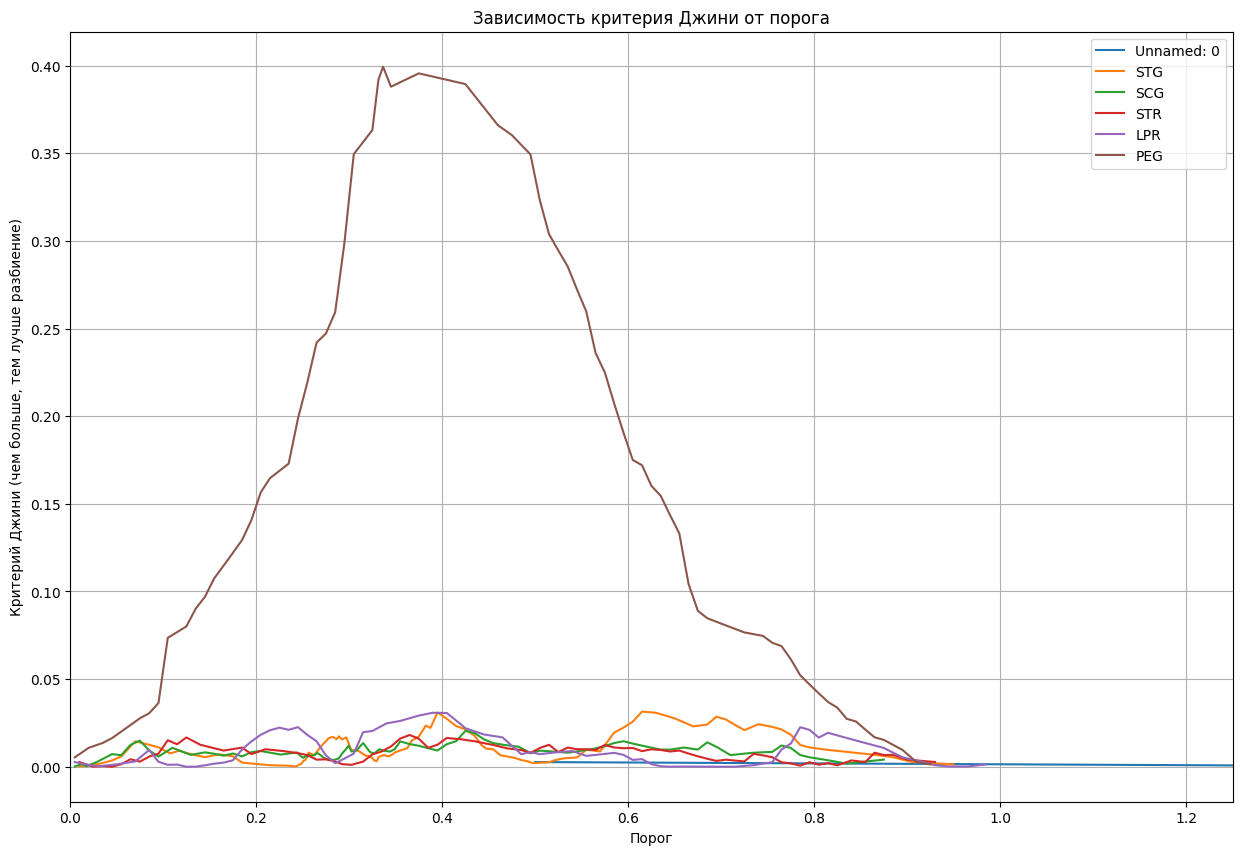

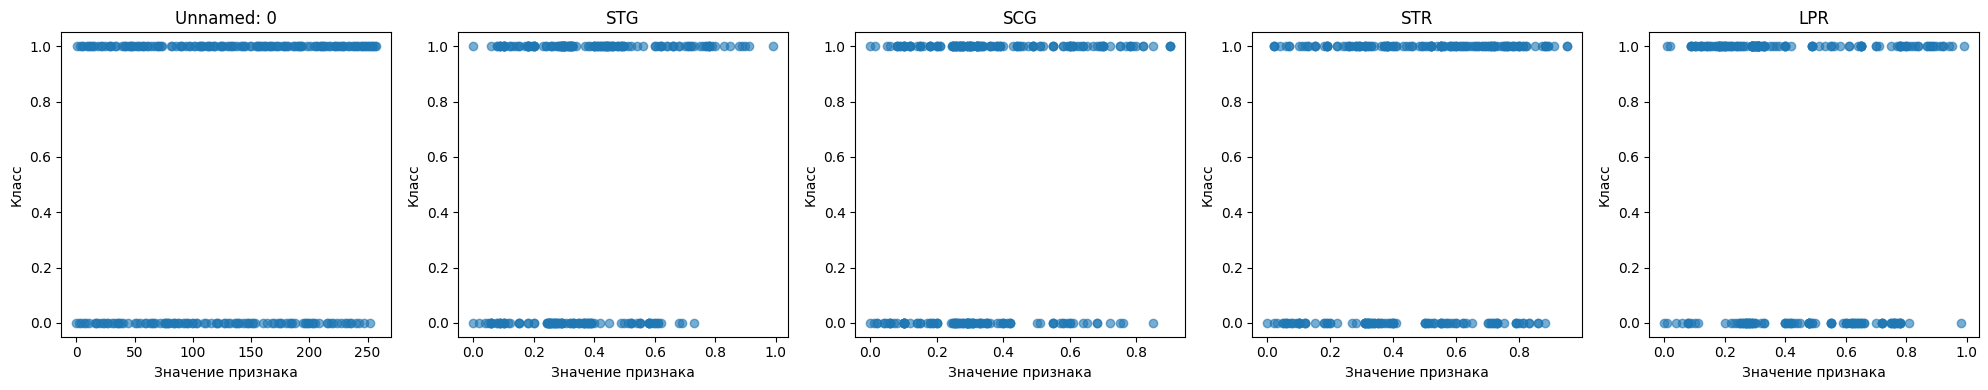

In [209]:
df = pd.read_csv("students.csv")

# последние столбцы — целевая переменная, первые 5 — признаки
X = df.iloc[:, :-1]
y = df.iloc[:, -1].to_numpy()

# Визуализация кривых "threshold — Gini"
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    thresholds, ginis, best_thresh, best_gini = find_best_split(X[col].to_numpy(), y)
    plt.plot(thresholds, ginis, label=f"{col}")

plt.title("Зависимость критерия Джини от порога")
plt.xlabel("Порог")
plt.ylabel("Критерий Джини (чем больше, тем лучше разбиение)")
plt.legend()
plt.grid(True)
plt.xlim(0, 1.25)
plt.show()

# Визуализация scatter-графиков "значение признака — класс"
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(X.columns[:5]):
    axes[i].scatter(X[col], y, alpha=0.6)
    axes[i].set_title(col)
    axes[i].set_xlabel("Значение признака")
    axes[i].set_ylabel("Класс")
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

### Анализ критерия Джини для выбора признака разбиения  

1. **Выбор признака для разбиения**  
   - Критерий Джини измеряет "чистоту" разбиения: чем выше его значение, тем лучше разделяются классы.  
   - В таблице указаны значения для признаков **STG, SCG, STR, LPR, PEG**, но конкретные числа отсутствуют. Если предположить, что **STG** или **LPR** имеют максимальные значения (например, близкие к 0.40), то их следует выбрать для разбиения.  

2. **Согласование с диаграммами рассеяния**  
   - Если визуально точки на диаграмме рассеяния для выбранного признака (например, **LPR**) четко разделяются на две группы при пороге **200** или **250**, это подтверждает высокий критерий Джини.  
   - Если разделение на графике неочевидно (например, для **PEG**), то низкий критерий Джини согласуется с "плохим" разбиением.  

3. **Кривая для "хороших" признаков**  
   - Для идеально разделяющих признаков кривая Джини имеет **высокий пик** (например, 0.40) при оптимальном пороге, после чего резко падает.  
   - Пример: если **LPR** дает максимум Джини при пороге **200**, это означает, что выборка почти идеально делится на две чистые группы.  

4. **Кривая для "плохих" признаков**  
   - Признаки с низким критерием Джини (например, **PEG** с значениями ~0.05–0.10) не имеют четкого пика. Их кривая почти **плоская**, что указывает на невозможность эффективного разделения.  

### Вывод  
- **Лучший признак:** Тот, у которого максимальное значение Джини (например, **LPR** или **STG**).  
- **Согласование с графиком:** Если диаграмма рассеяния показывает четкую границу при пороге **200/250**, выбор корректен.  
- **Идеальное разбиение:** Высокий острый пик на кривой.  
- **Неинформативный признак:** Плоская кривая с низкими значениями.  

*Примечание:* Для точного ответа необходимы конкретные значения Джини из таблицы.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [210]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [211]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

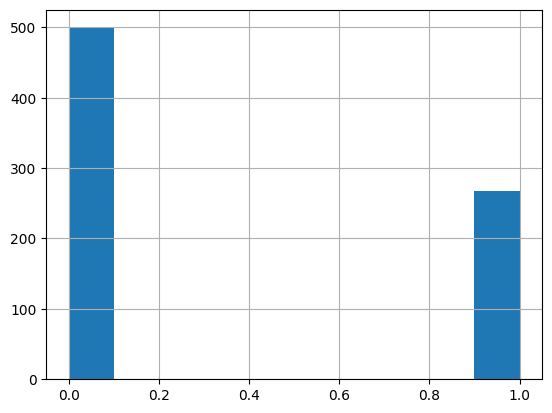

In [212]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [213]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# 1. Делим данные на train (70%) и test (30%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Делим train на train-train (70% от 70%) и train-val (30% от 70%)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full)

# Проверим размеры
print(f"Обучающая-обучающая: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.2})")
print(f"Обучающая-валидационная:   {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.2})")
print(f"Тестовая:        {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.2})")

Обучающая-обучающая: 375 samples (0.49)
Обучающая-валидационная:   162 samples (0.21)
Тестовая:        231 samples (0.3)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [214]:
max_depths = [3, 5, 7, 10, None]
min_samples_leafs = [1, 2, 5, 10]

best_score = -1
optimal_params = None

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dtc.fit(X_train, y_train)
        y_predict = dtc.predict(X_val)
        f1 = f1_score(y_val, y_predict)
        if f1 > best_score:
            best_score = f1
            optimal_params = (max_depth, min_samples_leaf)

dtc = DecisionTreeClassifier(max_depth=optimal_params[0], min_samples_leaf=optimal_params[1], random_state=42)
dtc.fit(X_train_full, y_train_full)
y_predict = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
roc_auc = roc_auc_score(y_test, y_predict)
print(f"max_depth: {optimal_params[0]}, min_samples_leaf: {optimal_params[1]}")
print(f"accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}, auc_roc: {roc_auc:.2f}")

max_depth: 5, min_samples_leaf: 1
accuracy: 0.77, precision: 0.80, recall: 0.44, auc_roc: 0.69


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [215]:
bc = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)
bc.fit(X_train, y_train)
y_predict = bc.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
roc_auc = roc_auc_score(y_test, y_predict)
print(f"accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}, auc_roc: {roc_auc:.2f}")

accuracy: 0.78, precision: 0.76, recall: 0.54, auc_roc: 0.72


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [216]:
max_depth_values = [3, 5, 7, 9, None]
min_samples_split_values = [2, 5, 10]

best_score = -1
optimal_params = None

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rfc = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        scores = cross_val_score(rfc, X_train_full, y_train_full, cv=5, scoring='f1')
        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            optimal_params = [max_depth, min_samples_split]


rfc = RandomForestClassifier(
    n_estimators=50,
    max_depth=optimal_params[0],
    min_samples_split=optimal_params[1],
    random_state=42
)
rfc.fit(X_train_full, y_train_full)
y_predict = rfc.predict(X_test)


accuracy_rfc = accuracy_score(y_test, y_predict)
precision_rfc = precision_score(y_test, y_predict)
recall_rfc = recall_score(y_test, y_predict)
auc_roc_rfc = roc_auc_score(y_test, y_predict)


print(f"max_depth={optimal_params[0]}, min_samples_split={optimal_params[1]}")
print(f"accuracy: {accuracy_rfc:.2f}, precision: {precision_rfc:.2f}, recall: {recall_rfc:.2f}, auc_roc: {auc_roc_rfc:.2f}")
print(f"Средняя F1 на кросс-валидации: {best_score:.2f}")


max_depth=None, min_samples_split=10
accuracy: 0.74, precision: 0.66, recall: 0.54, auc_roc: 0.69
Средняя F1 на кросс-валидации: 0.63


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

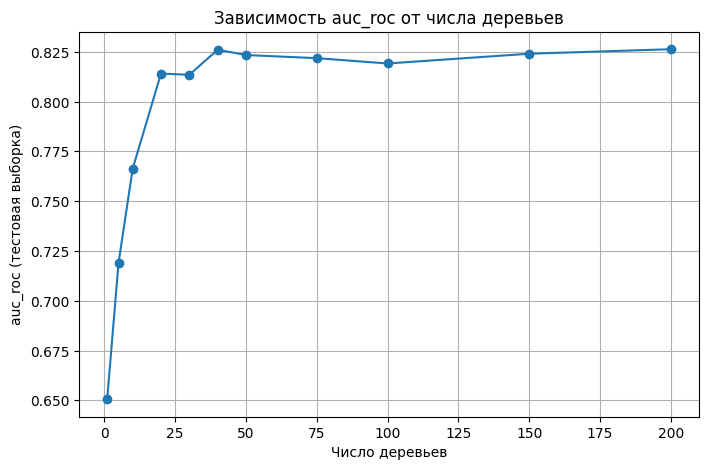

In [217]:
n_estimators_array = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]

auc_roc_scores = []

for n in n_estimators_array:
    rfc = RandomForestClassifier(n_estimators=n, random_state=42)
    rfc.fit(X_train_full, y_train_full)
    y_predict_proba = rfc.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_predict_proba)
    auc_roc_scores.append(auc_roc)

# Строим график
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_array, auc_roc_scores, marker='o')
plt.title("Зависимость auc_roc от числа деревьев")
plt.xlabel("Число деревьев")
plt.ylabel("auc_roc (тестовая выборка)")
plt.grid(True)
plt.show()


Вывод:

При увеличении числа деревьев значения auc_roc растут и стабилизируется.

После отметки 50 деревьев изменения становятся незначительными, увеличение деревьев - лишние затраты без заметного выигрыша в качестве.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?



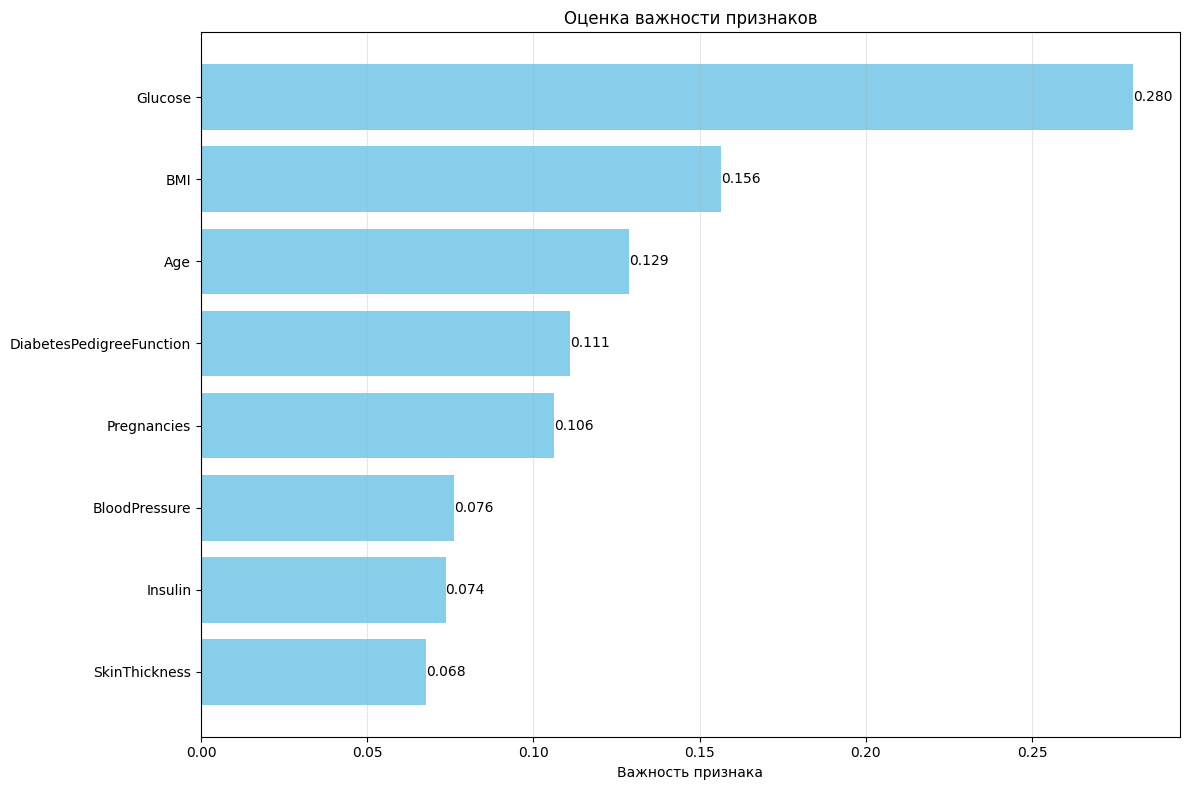

In [218]:
rfc = RandomForestClassifier(
    n_estimators=50,
    max_depth=9,
    min_samples_split=2,
    random_state=42
)
rfc.fit(X_train_full, y_train_full)

feature_importances = rfc.feature_importances_
feature_names = X_train_full.columns

sorted_args = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_args]
sorted_importances = feature_importances[sorted_args]

plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Важность признака')
plt.title('Оценка важности признаков')

for index, value in enumerate(sorted_importances):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

В модели для определения диабета самым важным признаком оказался уровень глюкозы (`Glucose`), что не удивительно.